# Homework 11

**Harvard University**<br>
**Fall 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date:** Saturday, December 1st, 2018 at 11:59pm

**Instructions:**

- Upload your final answers in the form of a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

### Collaborators

**Joe Davison<br>
Anna Davydova<br>
Michael S. Emanuel<br>
Dylan Randle**

<div class="answer-separator">
------------------------
</div>

In [1]:
import numpy as np
import scipy.stats
import scipy.special

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm

import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
# Additional imports
import pymc3 as pm
import pickle
from IPython.display import display, HTML
import warnings
from typing import Dict

In [3]:
# Serialization
def load_vartbl(fname: str) -> Dict:
    """Load a dictionary of variables from a pickled file"""
    try:
        with open(fname, 'rb') as fh:
            vartbl = pickle.load(fh)
    except:
        vartbl = dict()
    return vartbl


def save_vartbl(vartbl: Dict, fname: str) -> None:
    """Save a dictionary of variables to the given file with pickle"""
    with open(fname, 'wb') as fh:
        pickle.dump(vartbl, fh)

# Load persisted table of variables
fname: str = 'census_income.pickle'
vartbl: Dict = load_vartbl(fname)

In [4]:
# Set plot style
matplotlib.rcParams.update({'font.size': 20})

# Turn off deprecation warning triggered by theano
warnings.simplefilter('ignore')

## Question 1: Crazy Rich Bayesians Don't Need No Educations?

**coding required**

In this problem, you will explore how to recast data, tasks and research questions from a variety of different contexts so that an existing model can be applied for analysis.

Example 10.1.3 in ["Statistical Rethinking"](https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjopa0chtr7ns%2FStatistical_Rethinking_excerpt.pdf), the excerpt of which is included with this assignment, illustrates a study of the effect of an applicant's gender on graduate school admissions to six U.C. Berkeley departments through a comparison of four models. 

In this problem, you are given data from the [1994 U.S. Census](https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjop9zvsjoscq%2Fcensus_data.csv). The data has been processed so that only a subset of the features are present (for full dataset as well as the description see the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Census+Income)). You will be investigate the effect of gender on a person's yearly income in the dataset. In particular, we want to know how a person's gender effect the likelihood of their yearly salary being above or below \$50k. 

1.1. Read the dataset into a dataframe and aggregate the dataset by organizing the  dataframe into seven different categories. 

The categories we wish to consider are: 
* 4 year college degree
* Some-college or two year academic college degree
* High school
* Professional, vocational school
* Masters 
* Doctorate
* Some or no high school

Note that you might have to combine some of the existing education categories in your dataframe. For each category, we suggest that you only keep track of a count of the number of males and females who make above (and resp. below) the crazy rich income of $50k (see the dataset in Example 10.1.3). 

1.2. Following Example 10.1.3, build two models for the classification of an individual's yearly income (1 being above \$50k and 0 being below), one of these models should include the effect of gender while the other should not. 

1.3. Replicate the analysis in 10.1.3 using your models; specifically, compute wAIC scores and make a plot like Figure 10.5 (posterior check) to see how well your models fits the data. 

1.4. Following Example 10.1.3, build two models for the classification of an individual's yearly income taking into account education. One of the models should take into account education only the other should take into account gender and education on income.

1.5. Replicate the analysis in 10.1.3 using your models; specifically, compute wAIC scores and make a plot like Figure 10.6 (posterior check) to see how well your model fits the data.

1.6. Using your analysis from 1.3, discuss the effect gender has on income.

1.7. Using your analysis from 1.5, discuss the effect of gender on income taking into account an individual's education.

(**Hint: If you haven't seen WAIC, it's because we'll be covering it on Monday November 26, 2018.  In the meantime checkout info about WAIC in this resource on [PyMC3 model selection](https://docs.pymc.io/notebooks/model_comparison.html).**)

**1.1** 1.1. Read the dataset into a dataframe and aggregate the dataset by organizing the dataframe into seven different categories.

In [5]:
def load_data():
    """Load data and aggregate it by education and sex"""

    # Read in the full dataframe
    df_full = pd.read_csv('census_data.csv', index_col=0)
    
    # Map from census education categories to new categories
    education_map = {
        'Preschool' : 'Not-HS-Grad',
        '1st-4th' : 'Not-HS-Grad',
        '5th-6th' : 'Not-HS-Grad',
        '7th-8th' : 'Not-HS-Grad',
        '9th' : 'Not-HS-Grad',
        '10th' : 'Not-HS-Grad',
        '11th' : 'Not-HS-Grad',
        '12th' : 'Not-HS-Grad',
        'HS-grad': 'HS-Grad',
        'Some-college': 'College-Lite',
        'Assoc-acdm': 'College-Lite',
        'Assoc-voc': 'Prof-Voc',
        'Prof-school': 'Prof-Voc',
        'Bachelors': 'Bachelors',
        'Masters': 'Masters',
        'Doctorate': 'Doctorate'
        }
    
    educationID_map = {
        'Not-HS-Grad': 0,
        'HS-Grad': 1,
        'College-Lite': 2,
        'Prof-Voc': 3,
        'Bachelors': 4,
        'Masters': 5,
        'Doctorate': 6
    }
    
    sexID_map = {
            'Male' : 0,
            'Female' : 1
    }
    
    # Map from census income to a float (1.0 for high earning)
    earning_map =  {
        '<=50K': 0.0,
        '>50K': 1.0}
    
    # New series for education and earnings
    education = pd.Series(df_full.edu.map(education_map), name='education')
    education_id = pd.Series(education.map(educationID_map), name='education_id', dtype='category')
    # We also want the sex
    sex = df_full.sex
    sex_id = pd.Series(sex.map(sexID_map), name='sex_id', dtype='category')
    # The earnings (trying to predict this)
    earn_hi = pd.Series(df_full.earning.map(earning_map), name='earn_hi', dtype=np.int64)
    
    # Create a new dataframe
    df = pd.concat([education_id, sex_id, education, sex, earn_hi], axis=1, 
                   names=['education_id', 'sex_id', 'education', 'sex', 'earn_hi'])    
    # Aggregate counts of high and low earners by education for males and females as per hint
    # For each category, we suggest that you only keep track of a count of the number of males and females 
    # who make above (and resp. below) the crazy rich income of $50k (see the dataset in Example 10.1.3).
    # https://stackoverflow.com/questions/19384532/how-to-count-number-of-rows-per-group-and-other-statistics-in-pandas-group-by
    gb = df.groupby(by=[education_id, sex_id])
    counts = gb.size().to_frame(name='count')
    df_agg = counts.join(gb.agg({'earn_hi': 'sum'})).reset_index()
    # Change count column to 32 bit integer for compatibility with pymc3 sampling
    df_agg['count'] = df_agg['count'].astype(np.int32)
    # Add indicators is_male, is_female
    df_agg['is_male'] = np.zeros_like(df_agg.education_id, dtype=float)
    df_agg['is_female'] = np.zeros_like(df_agg.education_id, dtype=float)
    # High earning rate in each category
    df_agg['earn_hi_rate'] = df_agg['earn_hi'] / df_agg['count']
    # Return the dataframe    
    return df_agg, educationID_map, sexID_map

In [6]:
df, educationID_map, sexID_map = load_data()
display(df)

,education_id,sex_id,count,earn_hi,is_male,is_female,earn_hi_rate
0,0,0,2932,221,0.0,0.0,0.075375
1,0,1,1321,23,0.0,0.0,0.017411
2,1,0,7111,1449,0.0,0.0,0.203769
3,1,1,3390,226,0.0,0.0,0.066667
4,2,0,5131,1399,0.0,0.0,0.272656
5,2,1,3227,253,0.0,0.0,0.078401
6,3,0,1366,675,0.0,0.0,0.494143
7,3,1,592,109,0.0,0.0,0.184122
8,4,0,3736,1882,0.0,0.0,0.503747
9,4,1,1619,339,0.0,0.0,0.209389


**1.2** Following Example 10.1.3, build two models for the classification of an individual's yearly income (1 being above $50k and 0 being below), one of these models should include the effect of gender while the other should not.

In [7]:
# Shared configuration for all models in 1.2 & 1.4
# Number of educational categories
num_sex: int = len(sexID_map)
num_edu: int = len(educationID_map)

# Size for models
num_obs: int = len(df)

# Mean and Standard Deviation of distribution for alpha (constant term)
alpha_mu: float = 0.0
alpha_sd: float = 10.0

# Mean and Standard Deviation of distribution for beta (impact of sex on likelihood of high earnings)
beta_sex_mu: float = 0.0
beta_sex_sd: float = 10.0

# Mean and Standard Deviation of distribution for alpha by eductation
beta_edu_mu: float = 0.0
beta_edu_sd: float = 10.0

# The number of samples to draw
num_samples: int = 100000

In [8]:
# Create a baseline model with just a constant; name it model_base
with pm.Model() as model_base:
    # The alpha shared by all categories
    alpha = pm.Normal(name='alpha', mu=alpha_mu, sd=alpha_sd)
    # The logit for each category
    logit_p = pm.Deterministic('logit_p', alpha)
    # The probability follows logit(p_i) ~ alpha_i --> p_i ~ invlogit(alpha_i)
    p = pm.Deterministic('p', pm.math.invlogit(logit_p))
    # Data likelihood
    obs_earn = pm.Binomial('obs_earn', n=df['count'].values, p=p, observed=df['earn_hi'].values)

# Draw samples from model_base
try:
    trace_base = vartbl['trace_base']
    print(f'Loaded trace_base from variable table in {fname}.')
except:    
    with model_base:
        # Need to manually specify cores=1 or this blows up on windows.
        # this is a a known bug on pymc3
        # https://github.com/pymc-devs/pymc3/issues/3140
        trace_base = pm.sample(10000, chains=2, cores=1)
    vartbl['trace_base'] = trace_base
    save_vartbl(vartbl, fname)

Loaded trace_base from variable table in census_income.pickle.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000029198AAAFD0>,
      dtype=object)

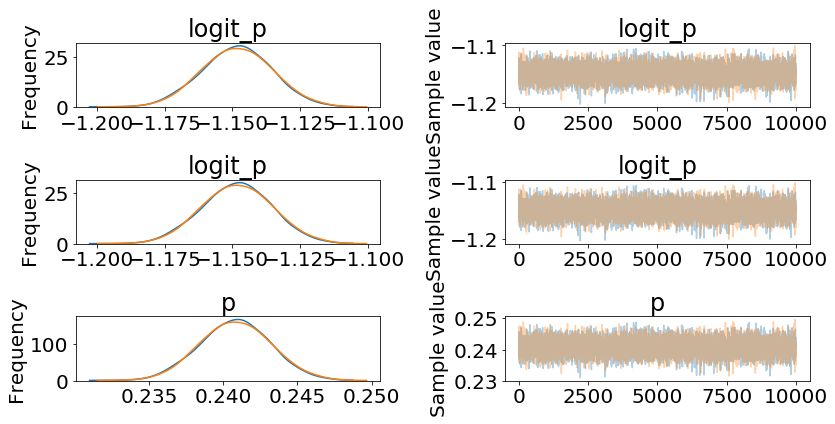

In [10]:
# Review outputs of model_base
display(pm.traceplot(trace_base))

In [11]:
# Create a model using only sex; name it model_sex
with pm.Model() as model_sex:
    # The beta for the two sex categories
    beta_sex = pm.Normal(name='beta_sex', mu=beta_sex_mu, sd=beta_sex_sd, shape=num_sex)
    # The logit for each category
    logit_p = pm.Deterministic('logit_p', beta_sex[df.sex_id])
    # The probability follows logit(p_i) ~ alpha_i --> p_i ~ invlogit(alpha_i)
    p = pm.Deterministic('p', pm.math.invlogit(logit_p))
    # Data likelihood
    obs_earn = pm.Binomial('obs_earn', n=df['count'].values, p=p, observed=df['earn_hi'].values)

# Draw samples from model_sex
try:
    trace_sex = vartbl['trace_sex']
    print(f'Loaded trace_sex from variable table in {fname}.')
except:    
    with model_sex:
        trace_sex = pm.sample(10000, chains=2, cores=1)
    vartbl['trace_sex'] = trace_sex
    save_vartbl(vartbl, fname)

Loaded trace_sex from variable table in census_income.pickle.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000029198B61588>,
      dtype=object)

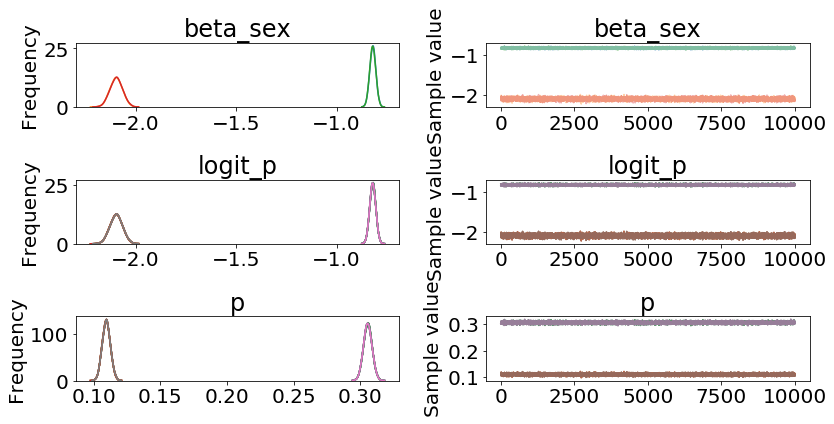

In [12]:
# Review outputs of model_sex
display(pm.traceplot(trace_sex))

**1.3**. Replicate the analysis in 10.1.3 using your models; specifically, compute wAIC scores and make a plot like Figure 10.5 (posterior check) to see how well your models fits the data.

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
sex,4647.35,489.24,0,0.52,1181.09,0,1
base,6184.66,404.91,1537.31,0.48,1588.8,1379.92,1


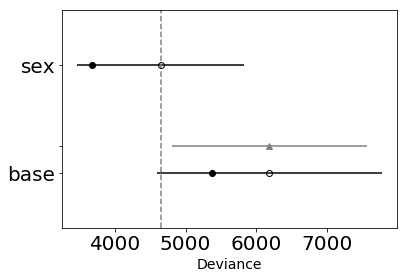

In [13]:
# Compute WAIC for both models
waic_base = pm.waic(trace_base, model_base)
waic_sex = pm.waic(trace_sex, model_sex)
# Set model names
model_base.name = 'base'
model_sex.name = 'sex'
# Comparison of WAIC
comp_WAIC_base_v_sex = pm.compare({model_base: trace_base, model_sex: trace_sex})
display(comp_WAIC_base_v_sex)
pm.compareplot(comp_WAIC_base_v_sex)

In [14]:
def plot_posterior(HER_data, HER_mean, HER_lo, HER_hi, model_name):
    """Generate the posterior validation plot following the example in Statistical Rethinking"""
    fig, ax = plt.subplots(figsize=[16,8])
    ax.set_title(f'Posterior Validation Check for {model_name} Model')
    # x axis for plots
    xx = np.arange(num_obs)
    ax.set_xticks(xx)
    ax.set_xlabel('Case')
    ax.set_ylabel('High Earning Rate (Above $50k)')

    # Actual data
    p1 = ax.plot(xx, HER_data, marker='o', color='b', markersize=8, linewidth=0, label='Data')
    # Lines between consecutive male / female pairs
    for i in range(num_obs // 2):
        i0 = 2*i
        i1 = i0+2
        ax.plot(xx[i0:i1], HER_data[i0:i1], marker=None, color='b')
    # Mean, Lo, and Hi model estimates
    p2 = ax.plot(xx, HER_lo, marker='_', color='k', markersize=10, linewidth=0, label='Low')
    p3 = ax.plot(xx, HER_mean, marker='o', color='r', markerfacecolor='None', markersize=10, linewidth=0, label='Mean')
    p4 = ax.plot(xx, HER_hi, marker='_', color='k', markersize=10, linewidth=0, label='High')
    # Vertical lines closing up whiskers
    for i in range(num_obs):
        ax.plot(np.array([i,i]), np.array([HER_lo[i], HER_hi[i]]), marker=None, color='k')

    # Legend
    handles = [p1[0], p2[0], p3[0], p4[0]]
    labels = ['Data', 'Low', 'Mean', 'High']
    ax.legend(handles, labels)
    ax.grid()
    plt.show()

In [15]:
# Generate the posterior predictive in both base and sex models
try:
    post_pred_base = vartbl['post_pred_base']
    post_pred_sex = vartbl['post_pred_sex']
    print(f'Loaded posterior predictive for base and sex models.')
except:
    with model_base:
        post_pred_base = pm.sample_ppc(trace_base)
    with model_sex:
        post_pred_sex = pm.sample_ppc(trace_sex)
    vartbl['post_pred_base'] = post_pred_base
    vartbl['post_pred_sex'] = post_pred_sex
    save_vartbl(vartbl, fname)

# True rate of high earners in each class
HER_data = df['earn_hi_rate'].values

# Mean, low (5.5th percentile), and high (94.5th percentile) estimates of high earning rate (HER) in base model
HER_mean_base = np.mean(post_pred_base['obs_earn'], axis=0) / df['count'].values
HER_lo_base = np.percentile(a=post_pred_base['obs_earn'],q=5.5, axis=0) / df['count'].values
HER_hi_base = np.percentile(a=post_pred_base['obs_earn'],q=94.5, axis=0) / df['count'].values

# HER in sex model
HER_mean_sex = np.mean(post_pred_sex['obs_earn'], axis=0) / df['count'].values
HER_lo_sex = np.percentile(a=post_pred_sex['obs_earn'],q=5.5, axis=0) / df['count'].values
HER_hi_sex = np.percentile(a=post_pred_sex['obs_earn'],q=94.5, axis=0) / df['count'].values

Loaded posterior predictive for base and sex models.


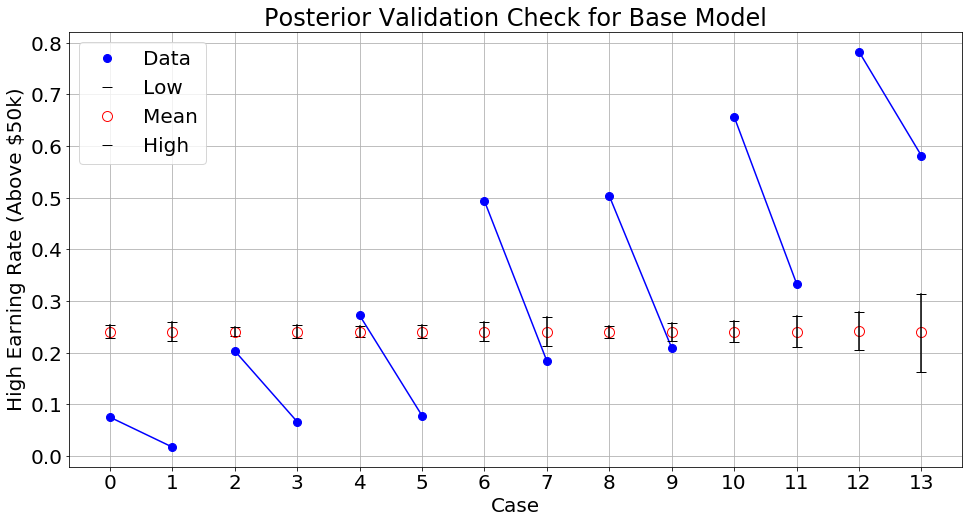

In [16]:
plot_posterior(HER_data, HER_mean_base, HER_lo_base, HER_hi_base, 'Base')

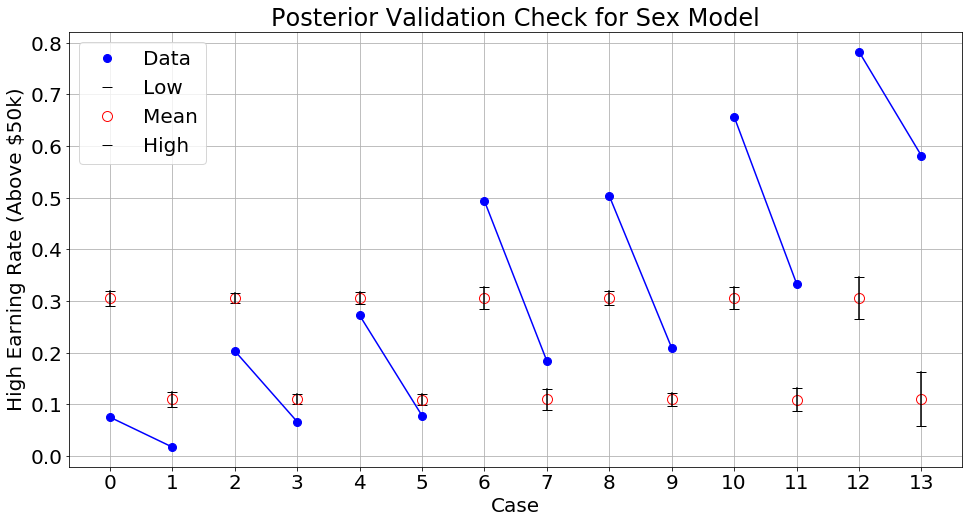

In [17]:
plot_posterior(HER_data, HER_mean_sex, HER_lo_sex, HER_hi_sex, 'Sex')

**1.4**. Following Example 10.1.3, build two models for the classification of an individual's yearly income taking into account education. One of the models should take into account education only the other should take into account gender and education on income.

In [18]:
# Create a model using only education; name it model_edu
with pm.Model() as model_edu:
    # The beta for each of the seven educational categories
    beta_edu = pm.Normal(name='beta_edu', mu=beta_edu_mu, sd=beta_edu_sd, shape=num_edu)
    # The logit for each category
    logit_p = pm.Deterministic('logit_p', beta_edu[df.education_id])
    # The probability follows logit(p_i) ~ alpha_i --> p_i ~ invlogit(alpha_i)
    p = pm.Deterministic('p', pm.math.invlogit(logit_p))
    # Data likelihood
    obs_earn = pm.Binomial('obs_earn', n=df['count'].values, p=p, observed=df['earn_hi'].values)

# Draw samples from model_edu
try:
    trace_edu = vartbl['trace_edu']
    print(f'Loaded trace_edu from {fname}.')
except:    
    with model_edu:
        trace_edu = pm.sample(10000, chains=2, cores=1)
    vartbl['trace_edu'] = trace_edu
    save_vartbl(vartbl, fname)

Loaded trace_edu from census_income.pickle.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002919C1C35C0>,
      dtype=object)

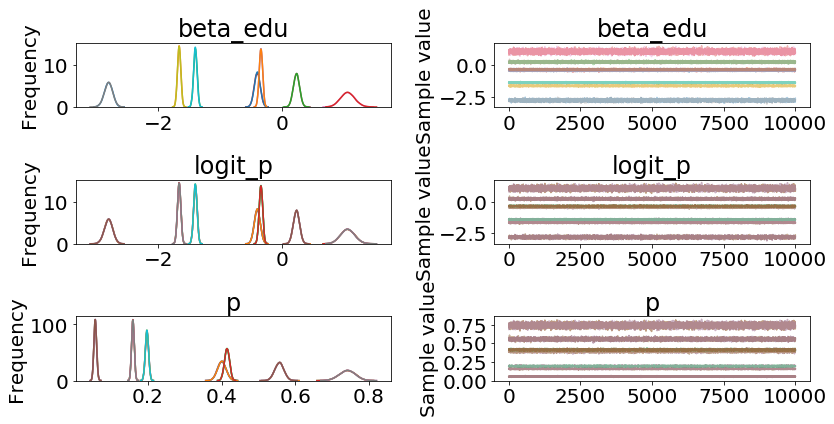

In [20]:
# Review outputs of model_edu
display(pm.traceplot(trace_edu))

In [21]:
# Create a model using both education and sex; name it model_edu_sex
with pm.Model() as model_edu_sex:
    # The beta for each of the seven educational categories
    beta_edu = pm.Normal(name='beta_edu', mu=beta_edu_mu, sd=beta_edu_sd, shape=num_edu)
    # The beta for the two sex categories
    beta_sex = pm.Normal(name='beta_sex', mu=beta_sex_mu, sd=beta_sex_sd, shape=num_sex)
    # The logit for each category
    logit_p = pm.Deterministic('logit_p', beta_edu[df.education_id] + beta_sex[df.sex_id])
    # The probability follows logit(p_i) ~ alpha_i --> p_i ~ invlogit(alpha_i)
    p = pm.Deterministic('p', pm.math.invlogit(logit_p))
    # Data likelihood
    obs_earn = pm.Binomial('obs_earn', n=df['count'].values, p=p, observed=df['earn_hi'].values)

# Draw samples from model_edu_sex
try:
    trace_edu_sex = vartbl['trace_edu_sex']
    print(f'Loaded trace_edu_sex from {fname}.')
except:    
    with model_edu_sex:
        model_edu_sex_trace = pm.sample(10000, chains=2, cores=1)
    vartbl['trace_edu_sex'] = trace_edu_sex
    save_vartbl(vartbl, fname)

Loaded trace_edu_sex from census_income.pickle.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000029198B491D0>,
      dtype=object)

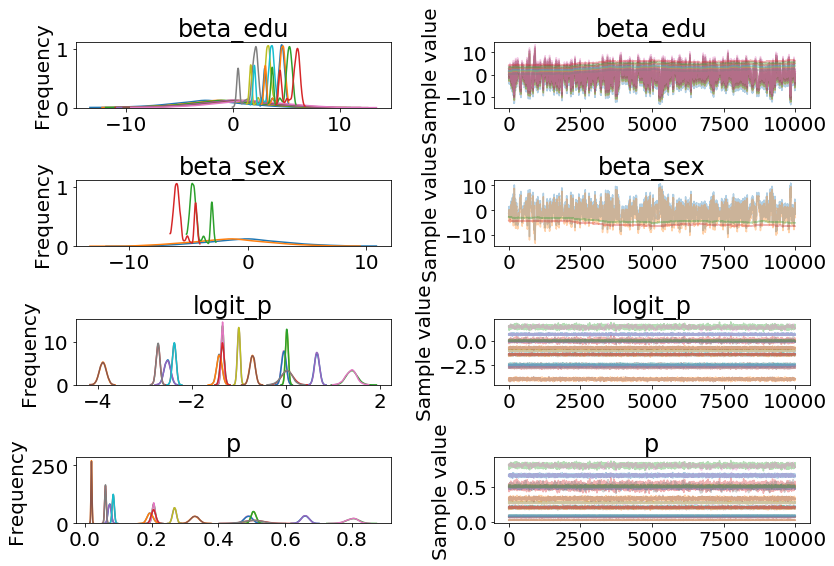

In [22]:
# Review outputs of model_edu_sex
display(pm.traceplot(trace_edu_sex))

**1.5**. Replicate the analysis in 10.1.3 using your models; specifically, compute wAIC scores and make a plot like Figure 10.6 (posterior check) to see how well your model fits the data.

In [23]:
# Compute WAIC for both models
waic_edu = pm.waic(trace_edu, model_edu)
waic_edu_sex = pm.waic(trace_edu_sex, model_edu_sex)
# Set model names
model_base.name = 'edu'
model_sex.name = 'edu_sex'
# Comparison of WAIC
comp_WAIC_edu_v_both = pm.compare({model_edu: trace_edu, model_edu_sex: trace_edu_sex})
display(comp_WAIC_edu_v_both)

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
1,123.21,6.1,0,1,5.64,0,1
0,2834.44,701.13,2711.23,0,584.82,581.8,1


In [24]:
# Generate the posterior predictive in both base and sex models
try:
    post_pred_edu = vartbl['post_pred_edu']
    post_pred_edu_sex = vartbl['post_pred_edu_sex']
    print(f'Loaded posterior predictive for edu and edu_sex models.')
except:
    with model_edu:
        post_pred_edu = pm.sample_ppc(trace_edu)
    with model_edu_sex:
        post_pred_edu_sex = pm.sample_ppc(trace_edu_sex)
    vartbl['post_pred_edu'] = post_pred_edu
    vartbl['post_pred_edu_sex'] = post_pred_edu_sex
    save_vartbl(vartbl, fname)

# Mean, low (5.5th percentile), and high (94.5th percentile) estimates of high earning rate (HER) in base model
HER_mean_edu = np.mean(post_pred_edu['obs_earn'], axis=0) / df['count'].values
HER_lo_edu = np.percentile(a=post_pred_edu['obs_earn'],q=5.5, axis=0) / df['count'].values
HER_hi_edu = np.percentile(a=post_pred_edu['obs_earn'],q=94.5, axis=0) / df['count'].values

# HER in sex model
HER_mean_edu_sex = np.mean(post_pred_edu_sex['obs_earn'], axis=0) / df['count'].values
HER_lo_edu_sex = np.percentile(a=post_pred_edu_sex['obs_earn'],q=5.5, axis=0) / df['count'].values
HER_hi_edu_sex = np.percentile(a=post_pred_edu_sex['obs_earn'],q=94.5, axis=0) / df['count'].values

Loaded posterior predictive for edu and edu_sex models.


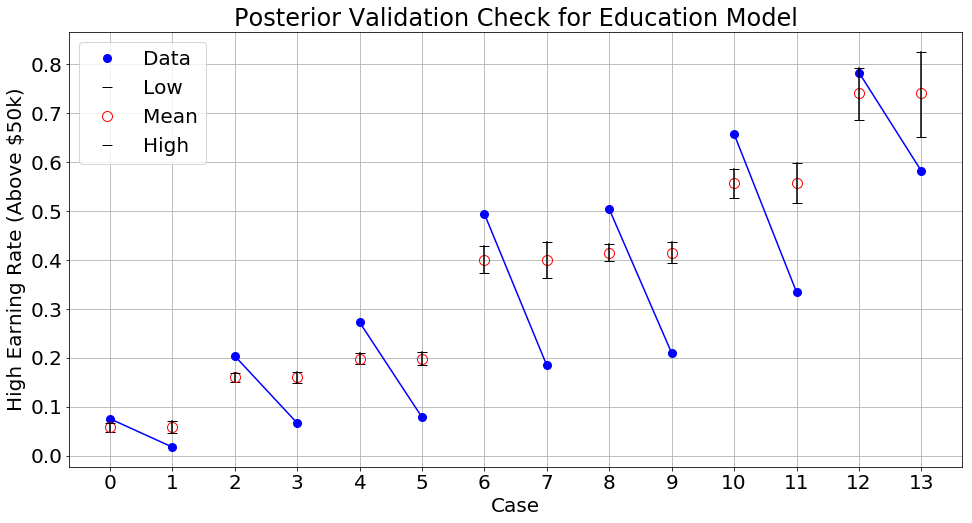

In [25]:
plot_posterior(HER_data, HER_mean_edu, HER_lo_edu, HER_hi_edu, 'Education')

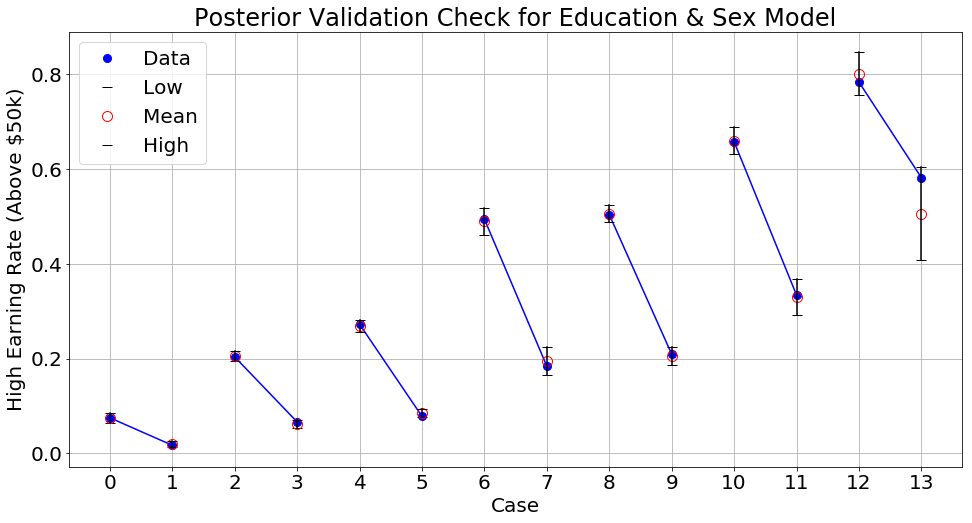

In [26]:
plot_posterior(HER_data, HER_mean_edu_sex, HER_lo_edu_sex, HER_hi_edu_sex, 'Education & Sex')

**1.6**. Using your analysis from 1.3, discuss the effect gender has on income.

In [27]:
pm.summary(trace_sex, varnames=['beta_sex', 'p'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_sex__0,-0.820011,0.014879,0.000089,-0.849283,-0.791063,21365.614354,1.000034
beta_sex__1,-2.096541,0.030792,0.000218,-2.157298,-2.037685,17572.456484,1.000171
p__0,0.305771,0.003158,0.000019,0.299583,0.311940,21361.073782,1.000034
p__1,0.109470,0.003001,0.000021,0.103651,0.115303,17582.695154,1.000176
p__2,0.305771,0.003158,0.000019,0.299583,0.311940,21361.073782,1.000034
p__3,0.109470,0.003001,0.000021,0.103651,0.115303,17582.695154,1.000176
p__4,0.305771,0.003158,0.000019,0.299583,0.311940,21361.073782,1.000034
p__5,0.109470,0.003001,0.000021,0.103651,0.115303,17582.695154,1.000176
p__6,0.305771,0.003158,0.000019,0.299583,0.311940,21361.073782,1.000034
p__7,0.109470,0.003001,0.000021,0.103651,0.115303,17582.695154,1.000176


In the analysis from 1.3, we considered two alternative models.  The baseline model made a single prediction for all 14 demographic groups that they had a 24.1\% probability of being high earners (above \\$50,000 / year).  The sex model took only one demographic variable into account.  It predicted that all males had a 30.6\% chance of being high earners and that all females had a 10.9 chance of being high earners.  The sex model is clearly a stronger model, and it is favored by the WAIC--though not overwhelmingly, because there is a large uncertainty in the parameter estimates.  The weightings are 52/48 in favor of the sex model.  The posterior validation check shows us at a quick glimpse that while the sex model fits the data better than the baseline, both models are a pretty poor fit for predicting the probability that a person earned over \$50,000 in 1994.  Just glancing at the pattern of the data, where the horizontal axis correlates with educational attainment, the pattern is clear that education is a stronger predictor than gender when predicting high income.  We can estimate the size of the effect by looking at the above summary from the trace of the sex model.  This shows that the difference is between -0.82 (males) and -2.09 (females) in logit space, corresponding to probabilities of about 10.9 and 30.6 percent, respectively.

My conlcusion is that gender has a real and measurable effect on the probability that someone in the 1994 census was a high earner, but that a model considering only sex is so weak that we should be reluctant to draw too many inferential conclusions without introducing additional variables that fit the data better.

**1.7**. Using your analysis from 1.5, discuss the effect of gender on income taking into account an individual's education.

In [28]:
pm.summary(trace_edu_sex, varnames=['beta_sex', 'beta_edu', 'p'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_sex__0,-2.143982,3.233705,0.228065,-5.773652,5.783717,1.975420,1.522568
beta_sex__1,-3.516916,3.233992,0.228082,-7.136439,4.426953,1.975651,1.522450
beta_edu__0,-0.379732,3.234625,0.228041,-8.259889,3.304650,1.976521,1.522164
beta_edu__1,0.795347,3.233828,0.228078,-7.163092,4.386539,1.975740,1.522484
beta_edu__2,1.141453,3.234194,0.228112,-6.818259,4.737191,1.975007,1.522712
beta_edu__3,2.101326,3.234873,0.228109,-5.807327,5.757355,1.975238,1.522690
beta_edu__4,2.164920,3.234140,0.228097,-5.786406,5.770180,1.975614,1.522530
beta_edu__5,2.805222,3.234179,0.228104,-5.170165,6.397952,1.974489,1.522817
beta_edu__6,3.538770,3.230461,0.227135,-4.357102,7.226929,1.986106,1.517950
p__0,0.074343,0.004583,0.000087,0.065443,0.083331,2636.394727,0.999951


In 1.5, we considered two models.  One predicted the rate of high earners using education alone, where education was compressed into seven categories as per the problem specification.  The second model took into account education and sex, assigning a beta weighting to each category.  The WAIC comparison shows that the two factor model incorporating sex and education is overwhelmingly superior to the model only incorporating education.  The pseudo-probability weightings between the two model are 100\% on the two factor model, 0\% on the education only model.  A quick look at the posterior predictive chart reaffirms that this model is doing a fine job on the data.  It is practically nailing 13 out of the 14 categories.  The only major error it makes is that it under-predicts the number of women holding doctoral degrees who are high earners.

I would add one word of caution however.  The number of effective parameters in the chart above is not nearly high enough, and Rhat parameter is too high.  I would like to spend more time tuning the sampling parameters to improve the quality of the samples.  But time is limited and this analysis is sufficient for the task at hand.

Given the quality of this fit, we are left with the sobering conclusion that in 1994, being female had a drastic effect on a person's probability of being a high earner.  For college graduates (categories 8 and 9 for men and women), we can see the men had a 50.5\% chance of high earnings compared to 20.6\% for women.  The numbers were similar for graduates of professional and vocational schools.  With a Masters degree, a man at this time had a 65.9\% chance of being high paid compared to just 32.9\% for women.  Finally for holders of doctoral degrees, the rates were 80\% for men and 50.5\% for women.

I do not believe that an analysis of this type is sufficient to form a firm conclusion about complex questions such as institutional sexism and the underpayment of women.  I would say that if you hold a simplified view of the labor market that a person's earning power is largely determined by their educational attainment, and that sex might also play a part, this analysis gives strong evidence that simply being female significantly hampered women's earnings prospects in 1994.

**Gratuitous Titular Reference**:  

If you haven't watched [Crazy Rich Asians](http://www.crazyrichasiansmovie.com/) then it might be time.

If you haven't listened to [Pink Floyd's](https://en.wikipedia.org/wiki/Pink_Floyd) [The Wall](https://en.wikipedia.org/wiki/The_Wall) then it might be time.

Also who are you? :-)

Anyway [You don't need no thought control](https://www.youtube.com/watch?v=YR5ApYxkU-U), [You probably want us teaching staff to leave you kids alone](https://www.youtube.com/watch?v=YR5ApYxkU-U), and [Education is overrated, right?  You don't need it!](https://www.youtube.com/watch?v=YR5ApYxkU-U)

<div class="answer-separator">
------------------------
</div>

## Question 2:  My Sister-In-Law's Baby Cousin Tracy ...

**coding required**

Wikipedia describes the National Annenberg Election Survey as follows -- "National Annenberg Election Survey (NAES) is the largest academic public opinion survey conducted during the American presidential elections. It is conducted by the Annenberg Public Policy Center at the University of Pennsylvania."  In the file [survey.csv](https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjop9sr9dh4g5%2Fsurvey.csv) we provide the following data from the 2004 National Annenberg Election Survey:  `age` -- the age of the respondents, `numr` -- the number of responses, and `knowlgbtq` -- the number of people at the given age who have at least one LGBTQ acquaintance.  We want you to model how age influences likelihood of interaction with members of the LGBTQ community in three ways. 


2.1. Using pymc3, create a bayesian linear regression model  with `age` as the quantitative predictor and `knowlgbtq` as the response variable. Plot the mean predictions for ages 0-100, with a 2-sigma envelope.

2.2. Using pymc3, create a 1-D Gaussian Process regression model with the same feature and dependent variables.  Use a squared exponential covariance function. Plot the mean predictions for ages 0-100, with a 2-sigma envelope.

(**Hint: For an example of GP Regression from class see [this GP Recap](http://am207.info/wiki/gpsalmon.html)**)

2.3. How do the models compare? Does age influence likelihood of acquaintance with someone LGBTQ? For Bayesian Linear Regression and GP Regression, how does age affect the variance of the estimates?


**Gratuitous Titular References**:  

Massachusett's own [Joiner Lucas](https://en.wikipedia.org/wiki/Joyner_Lucas) blew up in November 2017 with the release of his single ["I'm Not Racist"](https://www.youtube.com/watch?v=43gm3CJePn0) on Youtube.  The video quickly went viral. The title comes from the song's lyrics (and references that degrees of separation that can be involved in individual experience with members of any under-represented group).

Given the oncoming cold spell [Winter Blues](https://www.youtube.com/watch?v=I7_ofdl9Wfs) another popular track may be relevant.

<div class="answer-separator">
------------------------
</div>

## Question 3 - AM207 HWs Out (A OK I MIC DROP)!

**coding required**

In the dataset [reviews_processed.csv](https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjoyzcmjk5tv8%2Freviews_processed.csv), you'll find a database of Yelp reviews for a number of restaurants. These reviews have already been processed and transformed by someone who has completed the (pre) modeling process described in HW 10 Question 1. That is, imagine the dataset in "reviews_processed.csv" is the result of feeding the raw Yelp reviews through the pipeline someone built for that question.

The following is a full list of columns in the dataset and their meanings:

I. Relevant to 3.1-3.5:

  1. "review_id" - the unique identifier for each Yelp review
  2. "topic" - the subject addressed by the review (0 stands for food and 1 stands for service)
  3. "rid" - the unique identifier for each restaurant
  4. "count" - the number of sentences in a particular review on a particular topic
  5. "mean" - the probability of a sentence in a particular review on a particular topic being positive, averaged over total number of sentences in the review related to that topic.
  6. "var" - the variance of the probability of a sentence in a particular review on a particular topic being positive, taken over all sentences in the review related to that topic.

II. Relevant (possibly) to more complex models:

  1. "uavg" - the average star rating given by a particular reviewer (taken across all their reviews)
  2. "stars" - the number of stars given in a particular review
  3. "max" - the max probability of a sentence in a particular review on a particular topic being positive
  4. "min" - the min probability of a sentence in a particular review on a particular topic being positive

The following schema illustrates the model of the raw data that is used to generate "reviews_processed.csv":
<img src="https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjoz064i9yaxb%2Frestuarant_model.png" width=500/>

***Warning:*** *this is a "real" data science problem in the sense that the dataset in "reviews_processed.csv" is large. We understand that a number of you have limited computing resources, so you are encouraged but not required to use the entire dataset. If you wish you may use 10 restaurants from the dataset, as long as your choice of 10 contains a couple of restaurants with a large number of reviews and a couple with a small number of reviews.*


When the value in "count" is low, the "mean" value can be very skewed.

3.1. Following the [SAT prep school example discussed in lab](https://am207.info/wiki/gelmanschoolstheory.html) (and influenced your answers for HW 10 Question #1), set up a Bayesian model (that is, write functions encapsulating the pymc3 code) for a reviewer $j$'s opinion of restaurant $k$'s food and service (considering the food and service separately).  You should have a model for each restaurant and each aspect being reviewed (food and serivce). For restaurant $k$, you will have a model for $\{\theta_{jk}^{\text{food}}\}$ and one for $\{\theta_{jk}^{\text{service}}\}$, where $\theta_{jk}$ is the positivity of the opinion of the $j$-th reviewer regarding the $k$-th restaurant. 

**Hint:** What quantity in our data naturally corresponds to $\bar{y}_j$'s in the prep school example? How would you calculate the parameter $\sigma_j^2$ in the distribution of $\bar{y}_j$ (note that, contrary to the school example, $\sigma_j^2$ is not provided explictly in the restaurant data)?

3.2. Just to test your that modeling makes sense choose 1 restaurant and run your model from 3.1 on the food and service aspects for that restaurant.  Create 10K samples  each for the food and service model for your chosen restuarant and visualize your samples via a traceplot for each aspect of the restaurant reviews.

3.3. Use your model from 3.1 to produce estimates for $\theta_{jk}$'s for multiple restaurants. Pick a few (try for 5 but if computer power is a problem, choose 2) restaurants and for each aspect ("food" and "service") of each restaurant, plot your estimates for the $\theta$'s against the values in the "mean" column (corresponding to this restaurant). 

For the chosen restaurants, for each aspect ("food" and "service"), generate shrinkage plots and probability shrinkage plots as follows:

**Shrinkage plot for a restaurant, topic**:

> The aim for this plot is to see the shrinkage from sample means (error bars generated from standard error) to $\theta_{jk}$'s (error bars generated from theta variance).  
>
> The sample means of reviews are plotted at $y=0$ and the posterior means ($\theta_{ik}$) are plotted at $y=1$. For each review connect the sample mean to the posterior mean with a line.  Show error bars on the sample mean points using standard error and on the ($\theta_{jk}$) points using variance.

**Probability Shrinkage plot for a restaurant, topic**:

> The aim for this plot is to see the shrinkage from the classification probabilities from the sample means of reviews to the classification probabilities of $\theta_{jk}$'s.  The classification probabilities are calculated from the gaussian at the given mean and variance. The sample means and standard error are fed into the gaussian to generate one set of classification probabilities.  The $\theta_{jk}$ estimates and variances are fed into the gaussian to generate the other set of variances.
>
> The y values are the classification probability (calculated as 1-cdf) using the normal distribution at a given mean and variance.
>
> The sample means of reviews are plotted with $y$'s obtained by using the sample means as the means in the normal above, with line segments (error bars) representing the standard error. 
>
> The posterior means ($\theta_{jk}$) are plotted with $y$'s obtained using the posterior means (thetas) in the gaussian above, and variances on the thetas with line segments (error bars) representing the variances on the $\theta_{jk}$'s.
>
>We've provided you some code to generate a shrinkage plot and a probability shrinkage plot is included in this notebook, but feel free to implement your own. The code should also help elucidate the text above.

Example of a shrinkage plot:
<img src="https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjop9gx9xfww9%2Fshrinkage.png" width="400" height="400"/>

Example of a probability shrinkage plot:
<img src="https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlo4e4ari3r4wd%2Fj9vjyzv62x149%2Fjop9fsbbu9bs%2Fshrinkage_prob.png" width="400" height="400"/>


3.4. Based on your shrinkage plots and probability shrinkage plots in 3.3 discuss the statistical benefits of modeling each reviewer's opinion using your hierarchical model rather than approximating the reviewer opinion with the value in "mean".

3.5. Aggregate, in a simple but reasonable way, the reviewer's opinions given a pair of overall scores for each restaurant -- one for food and one for service. Rank the restaurants by food score and then by service score. 

(**Hint:**  Think what an average score for each aspect would do here?)

3.6. Discuss the statistical weakness of ranking by these scores.

(**Hint:** What is statistically problematic about the way you aggregated the reviews of each restaurant to produce an overall food or service score? This is also the same problem with summarizing a reviewer's opinion on a restaurants service and food based on what they write.)  


In [ ]:
import itertools

# Use 1-cdf at 0.5 to model the probability of having positive sentiment
# it basically tells you the area under the gaussian after 0.5 (we'll assume 
# positive sentiment based on the usual probability > 0.5 criterion)

prob = lambda mu, vari: .5 * (1 - erf((0.5- mu) / np.sqrt(2 * vari)))

# fix a restaurant and an aspect (food or service)
# "means" is the array of values in the "mean" column for the restaurant and the aspect 
#         in the dataset
# "thetas" is the array of values representing your estimate of the opinions of reviewers 
#          regarding this aspect of this particular restaurant
# "theta_vars" is the array of values of the varaiances of the thetas
# "counts" is the array of values in the "count" column for the restaurant and the aspect 
#.         in the dataset
# FEEL FREE TO RE-IMPLEMENT THESE

def shrinkage_plot(means, thetas, mean_vars, theta_vars, counts, ax):
    """
    a plot that shows how review means (plotted at y=0) shrink to
    review $theta$s, plotted at y=1
    """
    data = zip(means, thetas, mean_vars / counts, theta_vars, counts)   
    palette = itertools.cycle(sns.color_palette())
    with sns.axes_style('white'):
        for m,t, me, te, c in data: # mean, theta, mean errir, thetax error, count
            color=next(palette)
            # add some jitter to y values to separate them
            noise=0.04*np.random.randn()
            noise2=0.04*np.random.randn()
            if me==0:
                me = 4
            # plot shrinkage line from mean, 0 to
            # theta, 1. Also plot error bars
            ax.plot([m,t],[noise,1+noise2],'o-', color=color, lw=1)
            ax.errorbar([m,t],[noise,1+noise2], xerr=[np.sqrt(me), np.sqrt(te)], color=color,  lw=1)
        ax.set_yticks([])
        ax.set_xlim([0,1])
        sns.despine(offset=-2, trim=True, left=True)
    return plt.gca()

def prob_shrinkage_plot(means, thetas, mean_vars, theta_vars, counts, ax):
    """
    a plot that shows how review means (plotted at y=prob(mean)) shrink to
    review $theta$s, plotted at y=prob(theta)
    """
    data = zip(means, thetas, mean_vars / counts, theta_vars, counts)
    palette = itertools.cycle(sns.color_palette())
    with sns.axes_style('white'):
        for m,t, me, te, c in data: # mean, theta, mean errir, theta error, count
            color = next(palette)
            # add some jitter to y values to separate them
            noise = 0.001 * np.random.randn()
            noise2 = 0.001 * np.random.randn()
            if me == 0: #make mean error super large if estimated as 0 due to count=1
                me = 4
            p = prob(m, me)
            peb = prob(t, te)
            # plot shrinkage line from mean, prob-based_on-mean to
            # theta, prob-based_on-theta. Also plot error bars
            ax.plot([m, t],[p, peb],'o-', color=color, lw=1)
            ax.errorbar([m, t],[p + noise, peb + noise2], xerr=[np.sqrt(me), np.sqrt(te)], color=color, lw=1)
        ax = plt.gca()
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1.05])
    return ax

**Gratuitous Titular Reference**:  

Thank you for putting up with us -- No more HWs!  No more gratuitous titular references!

We'll leave with a [Steve Aoki](http://www.steveaoki.com/) and [K-Pop](https://en.wikipedia.org/wiki/K-pop) style [Mic Drop](https://www.youtube.com/watch?v=kTlv5_Bs8aw).  Take it away [BTS](https://en.wikipedia.org/wiki/BTS_(band)).  Don't [Burn the Stage](https://www.youtube.com/watch?v=uwgDg8YnU8U) on the way out!

[AM207 HW Crew out!](https://www.youtube.com/watch?v=Tg0hLMop200)

<div class="answer-separator">
------------------------
</div>